In [1]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install git+https://github.com/Effective-Quadratures/Effective-Quadratures.git@feature_robust # for specific branch

import numpy as np
import matplotlib.pyplot as plt

## Set up test

In [2]:
our_function = lambda x:  (0.3*x**4 -1.6*x**3 +0.6*x**2 +2.4*x - 0.5)*1
#our_function = lambda x:  1.8*x

In [3]:
N = 20 # number of training points (note, some will be removed below)
n = 3 # degree of polynomial
state = 15

x = np.sort((2*np.random.RandomState(state).rand(N,1)-1),axis=0)
noise_var = 0.01
y = our_function(x) + np.random.RandomState(state).randn(N,1)*np.sqrt(noise_var)
pos = ((x>0)*(x<0.3)).nonzero()[0]
x = np.delete(x,pos)[:,None].squeeze()
y = np.delete(y,pos)[:,None].squeeze() 

# outliers!
nout = 2
index = np.random.RandomState(state).choice(len(y),nout,replace=False)
print(index)
#y[index] += np.random.uniform(-1,1,nout,random_state=42)*4
y[index[0]] += 2.8
y[index[1]] -= 2.8

N = len(x)

dimensions = 1
if N < n: quit('N must exceed n')
    
x = x.reshape(-1,1)
xtest = np.linspace(-1,1,100).reshape(-1,1)
ytest = our_function(xtest)

[ 9 13]


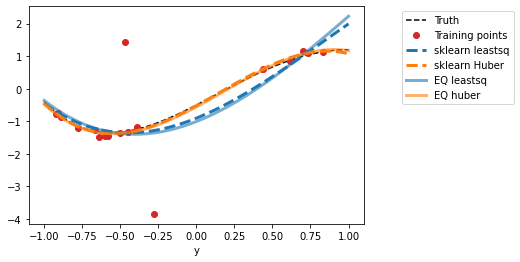

In [4]:
plt.plot(xtest,ytest,'k--',label='Truth')
plt.plot(x,y,'oC3',label='Training points')

from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(n), LinearRegression())
model.fit(x,y)
ypred = model.predict(xtest)
plt.plot(xtest,ypred,'C0--',label='sklearn leastsq',lw=3)

model = make_pipeline(PolynomialFeatures(n), HuberRegressor(epsilon=1.35,alpha=0))
model.fit(x,y)
ypred = model.predict(xtest)
plt.plot(xtest,ypred,'C1--',label='sklearn Huber',lw=3)

#model = make_pipeline(PolynomialFeatures(n), RANSACRegressor())
#model.fit(x,y)
#ypred = model.predict(xtest)
#plt.plot(xtest,ypred,'C2--',label='sklearn RANSAC',alpha=0.6,lw=3)

from equadratures import *
param = Parameter(distribution='uniform', lower=-1, upper=1, order=n)
basis = Basis('univariate')
poly = Poly(parameters=param, basis=basis, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points':x.reshape(-1,1), 'sample-outputs': y.reshape(-1,1)})
poly.set_model()
ypred = poly.get_polyfit(xtest.reshape(-1,1))
plt.plot(xtest,ypred,'C0-',label='EQ leastsq',lw=3,alpha=0.6)

poly = Poly(parameters=param, basis=basis, method='huber', \
              sampling_args= {'mesh': 'user-defined', 'sample-points':x.reshape(-1,1), 'sample-outputs': y.reshape(-1,1)},
           solver_args={'param1':1.35})
poly.set_model()
ypred = poly.get_polyfit(xtest.reshape(-1,1))
plt.plot(xtest,ypred,'C1-',label='EQ huber',lw=3,alpha=0.6)

#plt.ylim([-3,3])
plt.xlabel('x')
plt.xlabel('y')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()